# Import Libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model, to_categorical

from IPython import display

import warnings
warnings.filterwarnings("ignore")

/home/alper/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


# Load Data

In [2]:
(train_data, train_labels), (test_data, test_labels) = mnist.load_data()

In [3]:
train_data = train_data.reshape(-1, 28 * 28) / 255.0
test_data = test_data.reshape(-1, 28 * 28) / 255.0

In [4]:
train_labels = to_categorical(train_labels, 10)
test_labels = to_categorical(test_labels, 10)

# Visualization

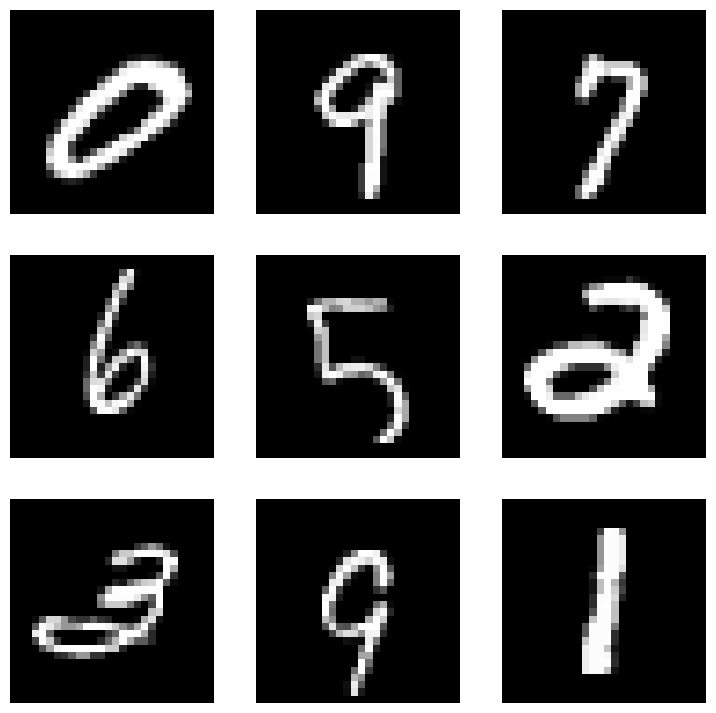

In [5]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))

for i, axs in enumerate(axes.flatten()):
    random_idx = np.random.randint(len(train_data))
    axs.imshow(train_data[random_idx].reshape(28, 28), cmap="gray")
    axs.axis("off")

plt.show()

# Model

In [6]:
class RBFNetwork(models.Model):
    def __init__(self, centers, beta, dist="gaussian"):
        super(RBFNetwork, self).__init__()
        self.centers = tf.constant(centers, dtype=tf.float32)
        self.beta = beta
        self.dist = dist
        self.dense = layers.Dense(10, activation="softmax")
    
    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=1)
        centers = tf.expand_dims(self.centers, axis=0)
        distances = tf.reduce_sum(tf.square(x - centers), axis=2)
        if self.dist == "gaussian":
            rbf_output = tf.exp(-self.beta * distances)
        elif self.dist == "multiquadratic":
            rbf_output = tf.sqrt(distances + (1 / (self.beta ** 2)))
        elif self.dist == "inverse-multiquadratic":
            rbf_output = 1.0 / tf.sqrt(distances + (1 / (self.beta ** 2)))
        elif self.dist == "linear":
            rbf_output = distances
            
        return self.dense(rbf_output)

In [7]:
num_centers = 100
kmeans = KMeans(n_clusters=num_centers, random_state=0)
kmeans.fit(train_data)
centers = kmeans.cluster_centers_ 

In [8]:
center_distances = np.sqrt(np.sum((centers[:, None, :] - centers[None, :, :])**2, axis=-1))
beta = 1.0 / (2 * (np.mean(center_distances) ** 2))

In [20]:
model = RBFNetwork(centers=centers, beta=beta, dist="linear")

In [21]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train

In [22]:
tensorboard_callback = callbacks.TensorBoard(log_dir='./logs')

In [23]:
history = model.fit(
    train_data,
    train_labels,
    epochs = 10,
    batch_size = 16,
    validation_data=(test_data, test_labels),
    verbose = 1
)

Epoch 1/10
3750/3750 [==============================] - 13s 3ms/step - loss: 4.3686 - accuracy: 0.6626 - val_loss: 1.8030 - val_accuracy: 0.7692
Epoch 2/10
3750/3750 [==============================] - 13s 4ms/step - loss: 1.8395 - accuracy: 0.7782 - val_loss: 1.4393 - val_accuracy: 0.8158
Epoch 3/10
3750/3750 [==============================] - 13s 3ms/step - loss: 1.6543 - accuracy: 0.7972 - val_loss: 1.8483 - val_accuracy: 0.7790
Epoch 4/10
3750/3750 [==============================] - 13s 3ms/step - loss: 1.5397 - accuracy: 0.8042 - val_loss: 1.2099 - val_accuracy: 0.8318
Epoch 5/10
3750/3750 [==============================] - 13s 3ms/step - loss: 1.5143 - accuracy: 0.8103 - val_loss: 2.1986 - val_accuracy: 0.7538
Epoch 6/10
3750/3750 [==============================] - 12s 3ms/step - loss: 1.4870 - accuracy: 0.8129 - val_loss: 1.5677 - val_accuracy: 0.7898
Epoch 7/10
3750/3750 [==============================] - 14s 4ms/step - loss: 1.5026 - accuracy: 0.8155 - val_loss: 1.1380 - val_ac

# Results

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.head()

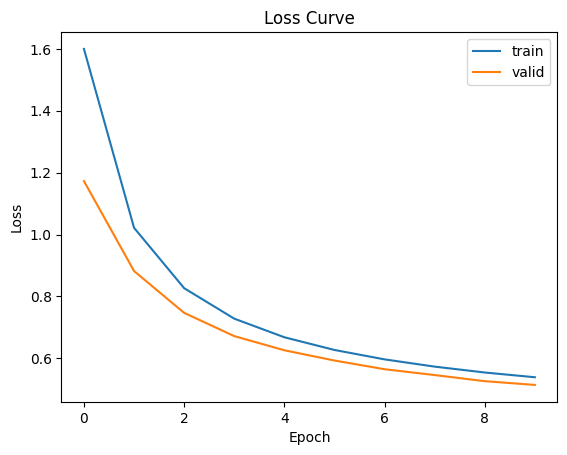

In [14]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "valid"])
plt.title("Loss Curve")
plt.show()

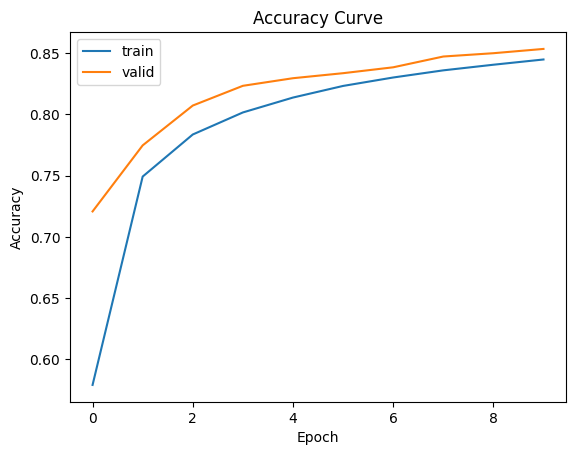

In [15]:
plt.figure()
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["train", "valid"])
plt.title("Accuracy Curve")
plt.show()